In [1]:
%run ../template.ipynb

In [2]:
exp_id = "050318"
series_names = ["mainstream", "maxsharing", "nosharing"]
num_apps_range = range(3, 4+1)
# num_apps_range = range(3, 5+1)

In [3]:
setups = {}
for num_apps in num_apps_range:
    setups.update(dataloaders.load_setups(exp_id,
                                          setup_file_str="/setups.{exp_id}-" + str(num_apps) + "{version}.pickle",
                                          legacy='InconsistentIds'))

Loading setups... Using InconsistentIds... Done
Loading setups... Using InconsistentIds... Done


In [4]:
# %prun dataloaders.load_setups(exp_id, setup_file_str="/setups.{exp_id}-5{version}.pickle")

In [5]:
# %prun dataloaders.load_schedules("050318", "greedy." + series_names[-1] + ".sim.*-5.v1", setups=setups)

In [6]:
rows = []
for series_name in series_names:
    schedules = []
    for num_apps in num_apps_range:
        schedules += dataloaders.load_schedules("050318", "greedy." + series_name + ".sim.*-" + str(num_apps) + ".v1", variant='v1+metrics', setups=setups)
    # Extract some attributes from the schedules.
    # Add on some based on the file name.
    rows += ex(schedules,
               each=lambda s: {'f1': mean(s.f1s), 'fps': mean(s.fpses), 'num_apps': s.num_apps, 'budget': s.budget},
               constant={'scheduler': 'greedy', 'sharing': series_name})
df = comb(rows)

In [7]:
# See Pandas: Group By: split-apply-combine
# https://pandas.pydata.org/pandas-docs/stable/groupby.html
df_view = df[df['budget'] == 100]
# Group <setups> by number of apps, aggregate by mean.
# Make sure that the right-most index is the x-axis.
grouped = df_view.groupby(['sharing', 'num_apps'])

# Original way (and most flexible) of doing it
xss, yss = agg2xy(grouped['f1'].mean(), names=series_names)
series = get_series(xss, yss,
                    names=series_names,
                    plotparams=dict(lw=2, markersize=8))

# Neater way to do it if you don't need xss/yss
series2 = agg2series(grouped['fps'].mean(),
                     names=series_names,
                     plotstyles=styles.SERIES_ALT,
                     plotparams=dict(lw=1, markersize=8, alpha=0.7, linestyle='--'))

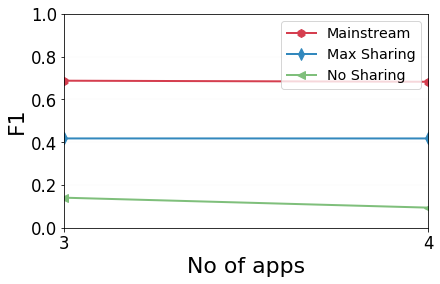

In [8]:
# You can call grids.x/grids.y directly, or supply it as parameters.
plot.variants(series)
grids.y.f1(yss)
grids.x.num_apps(xss)

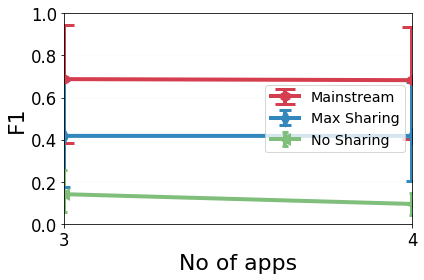

In [9]:
# With error bars
bars = [grouped['f1'].min(), grouped['f1'].max()]
series3 = agg2series(grouped['f1'].mean(),
                     names=series_names,
                     errs=dict(e_abs=bars),
                     plotparams=dict(lw=4, markersize=8, markeredgewidth=3))
plot.variants(series3, xgrid=grids.x.num_apps, ygrid=grids.y.f1)

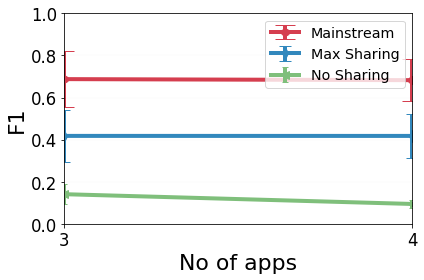

In [10]:
# With error bars
bars = grouped['f1'].std()
series3 = agg2series(grouped['f1'].mean(),
                     names=series_names,
                     errs=dict(e_delta=bars),
                     plotparams=dict(lw=4, markersize=8))
ax = plot.variants(series3, xgrid=grids.x.num_apps, ygrid=grids.y.f1)

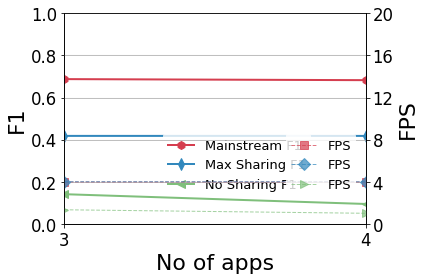

In [11]:
ax1, ax2 = plot.variants_dual(series, series2,
                              xgrid=grids.x.num_apps,
                              ygrid=grids.y.f1,
                              ygrid2=grids.y.fps)
legends.dual_fps(ax1, ax2, left='F1')
# save('scheduler', exp_id, 'f1-7hybrid-dual')

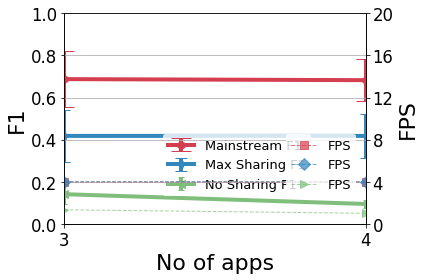

In [12]:
ax1, ax2 = plot.variants_dual(series3, series2,
                              xgrid=grids.x.num_apps,
                              ygrid=grids.y.f1,
                              ygrid2=grids.y.fps)
legends.dual_fps(ax1, ax2, left='F1')